# L3: Multi-agent Customer Support Automation

In this lesson, you will learn about the six key elements which help make Agents perform even better:
- Role Playing
- Focus
- Tools
- Cooperation
- Guardrails
- Memory

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, API and LLM

In [2]:
from crewai import Agent, Task, Crew

In [3]:
import os
from utils import get_openai_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'

## Role Playing, Focus and Cooperation

In [4]:
support_agent = Agent(
    role="Senior Support Representative",
	goal="Be the most friendly and helpful "
        "support representative in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        " are now working on providing "
		"support to {customer}, a super important customer "
        " for your company."
		"You need to make sure that you provide the best support!"
		"Make sure to provide full complete answers, "
        " and make no assumptions."
	),
	allow_delegation=False,
	verbose=True
)

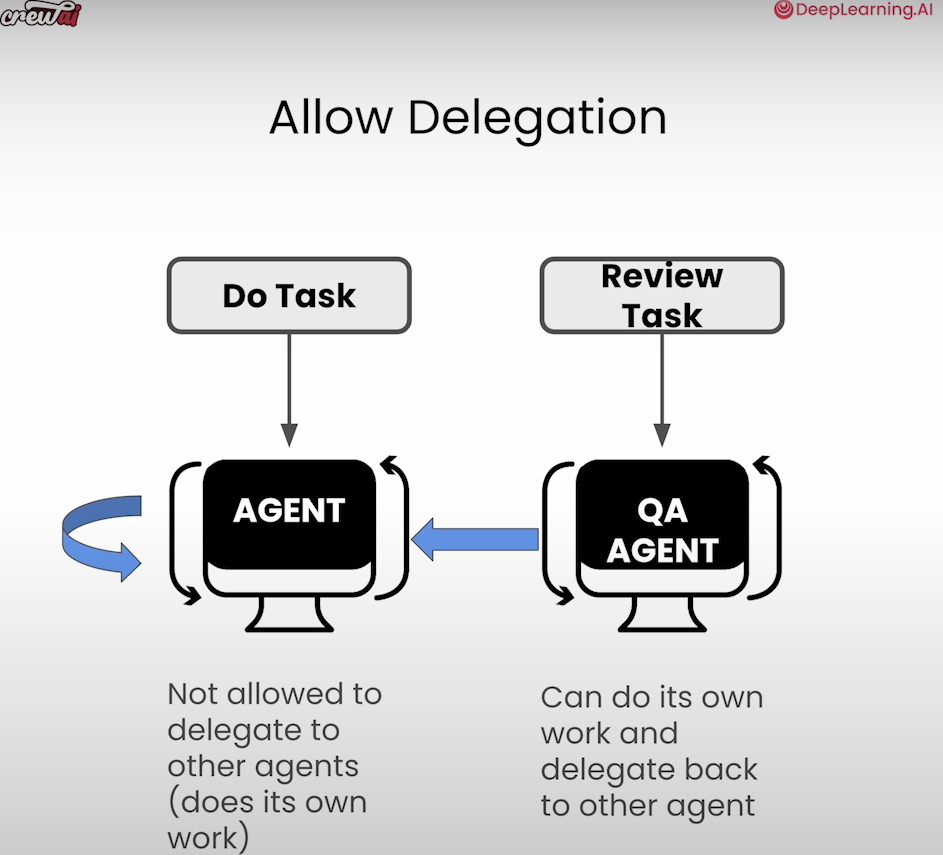

QA Agent, make sure that if they find something that doesn't feel right, they don't necessarily need to fix themselves but they can actually delegated back to another agent that might be better suited to do it, because either has like the right set of tools or the right set of backstory, goals and roles.

Q: **When exactly an agent decides that's resonable to delegate work to anaother or to ask questions to another?**

A: AI app have fuzzy i/p, fuzzy transformation & fuzzy o/p meaning they dont necessarily follow the same pattern all the time. So here the brain, LLMs,to make conscious reasonable call on when to delegate and when not to delegate. 

these models have a level of cognition, because they understand the language. So depending on the customer inquiry, they may understand that it's worth delegating and to do more research. But if it's more simple inquiry that demands a simpler answer, you might not want to delegate it back. So this is not something that you necessarily will have full control off.

Allowing an agent to delegate work and ask questions don't necessarily imply that it's going to do it every time, but that instead will give it the option to do so if it chooses to.

So this is one way on how you can get your agents to collaborate together in a great example, and how collaboration helps with better quality responses.

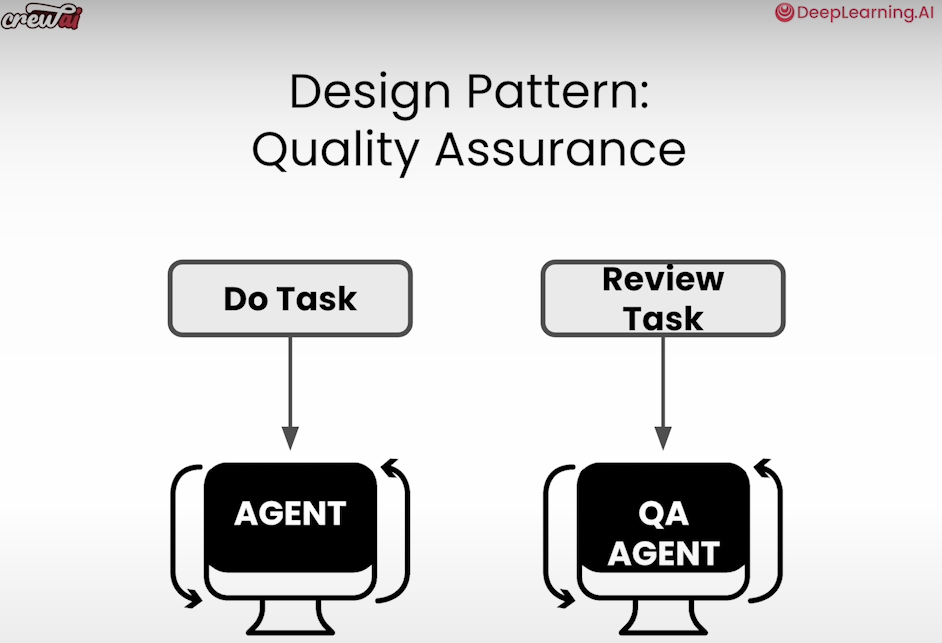

Agent that is kind of like a quality assurance agent helps a lot because they can do a final pass on whatever you want to do: writing a blog post, entering a customer, whatever it might be. So considering adding a QA agent of sorts into whatever multi-agent systems that you do,and that does tend to perform better than regular, regular agents without it.

- By not setting `allow_delegation=False`, `allow_delegation` takes its default value of being `True`.
- This means the agent _can_ delegate its work to another agent which is better suited to do a particular task. 

In [5]:
support_quality_assurance_agent = Agent(
	role="Support Quality Assurance Specialist",
	goal="Get recognition for providing the "
    "best support quality assurance in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        "are now working with your team "
		"on a request from {customer} ensuring that "
        "the support representative is "
		"providing the best support possible.\n"
		"You need to make sure that the support representative "
        "is providing full"
		"complete answers, and make no assumptions."
	),
	verbose=True
)

* **Role Playing**: Both agents have been given a role, goal and backstory.
* **Focus**: Both agents have been prompted to get into the character of the roles they are playing.
* **Cooperation**: Support Quality Assurance Agent can delegate work back to the Support Agent, allowing for these agents to work together.

## Tools, Guardrails and Memory

### Tools

- Import CrewAI tools

In [6]:
from crewai_tools import SerperDevTool, \
                         ScrapeWebsiteTool, \
                         WebsiteSearchTool

### Possible Custom Tools
- Load customer data
- Tap into previous conversations
- Load data from a CRM
- Checking existing bug reports
- Checking existing feature requests
- Checking ongoing tickets
- ... and more

- Some ways of using CrewAI tools.

```Python
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()
```

SerperDev tool to basically integrates with server. It's an external service that allows you to search Google. 

Scrape website is a simple scraper that allows your agent to access a given url and extract the contents of that. 

And the website search tool, is actually doing RAG over a website.

- Instantiate a document scraper tool.
- The tool will scrape a page (only 1 URL) of the CrewAI documentation.

In [7]:
docs_scrape_tool = ScrapeWebsiteTool(
    website_url="https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"
)

a. ScrapeWebsiteTool()

using the same tool, but one tool, would allow your agent to scrape any URL that it becomes aware of, as long as the agent teams that are scraping that URL would be beneficial.

b. ScrapeWebsiteTool(    website_url="https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/")

The second one allows your agent only to scrape one 10:05 certain URL, and not every URL that it finds.

##### Different Ways to Give Agents Tools

- Agent Level: The Agent can use the Tool(s) on any Task it performs.
- Task Level: The Agent will only use the Tool(s) when performing that specific Task.

**Note**: Task Tools override the Agent Tools.

So an agent might have ten tools at his disposal. But when performing a given task, if that task only says that it has three tools at his disposal, then the agent will only use those three tools.

### Creating Tasks
- You are passing the Tool on the Task Level.

In [8]:
inquiry_resolution = Task(
    description=(
        "{customer} just reached out with a super important ask:\n"
	    "{inquiry}\n\n"
        "{person} from {customer} is the one that reached out. "
		"Make sure to use everything you know "
        "to provide the best support possible."
		"You must strive to provide a complete "
        "and accurate response to the customer's inquiry."
    ),
    expected_output=(
	    "A detailed, informative response to the "
        "customer's inquiry that addresses "
        "all aspects of their question.\n"
        "The response should include references "
        "to everything you used to find the answer, "
        "including external data or solutions. "
        "Ensure the answer is complete, "
		"leaving no questions unanswered, and maintain a helpful and friendly "
		"tone throughout."
    ),
	tools=[docs_scrape_tool],
    agent=support_agent,
)

- `quality_assurance_review` is not using any Tool(s)
- Here the QA Agent will only review the work of the Support Agent

In [9]:
quality_assurance_review = Task(
    description=(
        "Review the response drafted by the Senior Support Representative for {customer}'s inquiry. "
        "Ensure that the answer is comprehensive, accurate, and adheres to the "
		"high-quality standards expected for customer support.\n"
        "Verify that all parts of the customer's inquiry "
        "have been addressed "
		"thoroughly, with a helpful and friendly tone.\n"
        "Check for references and sources used to "
        " find the information, "
		"ensuring the response is well-supported and "
        "leaves no questions unanswered."
    ),
    expected_output=(
        "A final, detailed, and informative response "
        "ready to be sent to the customer.\n"
        "This response should fully address the "
        "customer's inquiry, incorporating all "
		"relevant feedback and improvements.\n"
		"Don't be too formal, we are a chill and cool company "
	    "but maintain a professional and friendly tone throughout."
    ),
    agent=support_quality_assurance_agent,
)


### Creating the Crew

#### Memory
- Setting `memory=True` when putting the crew together enables Memory.

This single settings will enable The short term memory, the long term memory and the entity memory.

In [10]:
crew = Crew(
  agents=[support_agent, support_quality_assurance_agent],
  tasks=[inquiry_resolution, quality_assurance_review],
  verbose=2,
  memory=True
)

### Running the Crew

**Note**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

- In order to execute this crew, we need to pass inputs to it.We need to basically override all those interpolations that we did in the tasks and in the agents definitions. 

- So in this case we had three main interpolation variables - the customer ,the person and the inquiry.

#### Guardrails
- By running the execution below, you can see that the agents and the responses are within the scope of what we expect from them.

In [11]:
inputs = {
    "customer": "DeepLearningAI",
    "person": "Andrew Ng",
    "inquiry": "I need help with setting up a Crew "
               "and kicking it off, specifically "
               "how can I add memory to my crew? "
               "Can you provide guidance?"
}
result = crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Senior Support Representative
 [INFO]: == Starting Task: DeepLearningAI just reached out with a super important ask:
I need help with setting up a Crew and kicking it off, specifically how can I add memory to my crew? Can you provide guidance?

Andrew Ng from DeepLearningAI is the one that reached out. Make sure to use everything you know to provide the best support possible.You must strive to provide a complete and accurate response to the customer's inquiry.


> Entering new CrewAgentExecutor chain...
I need to provide the best possible support to DeepLearningAI regarding setting up a Crew and adding memory to it. I should use the "Read website content" tool to gather all the necessary information to give a detailed and accurate response.

Action: Read website content
Action Input: {"url": "https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"} 

Assembling and Activating Your CrewAI Team - crewAI
 Skip to content
 crewAI
 Assembling and Activat



> Entering new CrewAgentExecutor chain...


Inserting batches in chromadb: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


- Display the final result as Markdown.

In [12]:
from IPython.display import Markdown
Markdown(result)

Dear Andrew Ng,

Thank you for reaching out with your question regarding setting up a Crew and adding memory to it. I have gathered all the necessary information from our documentation on how to create and kick off a Crew using crewAI.

To set up a Crew and add memory to it, you can follow these steps:

1. Assemble Your Agents: Define your agents with distinct roles, backstories, and enhanced capabilities like memory usage. You can create agents with memory capabilities by setting the "memory" parameter to True in the Agent creation process.

2. Define the Tasks: Detail the specific objectives for your agents, including tasks that require memory usage. You can create tasks that utilize memory by assigning them to agents with memory capabilities.

3. Form the Crew: Combine your agents into a crew, setting the workflow process they'll follow to accomplish the tasks. You can configure the crew to use memory by setting the "memory" parameter to True in the Crew creation process.

4. Kick It Off: Initiate the process with your enhanced crew ready. Your agents will collaborate, leveraging their memory capabilities for a successful project outcome.

By following these steps, you can set up a Crew with memory capabilities and kick off your project successfully. If you need further assistance or have any more questions, feel free to reach out to us at any time.

Thank you for choosing crewAI for your AI project needs. We are here to support you every step of the way.

Best regards,
[Your Name]
Senior Support Representative
crewAI